## Implicit Quantile Networks (IQN) with PyTorch
The objective of this notebook is to implement the [Implicit Quantile Networks](https://arxiv.org/pdf/1806.06923.pdf) paper written by DeepMind in 2018. With limited guides/tutorials available on getting IQN working, I hope this notebook can be valuable.

Implicit quantile networks generalise the [Quantile Regression DQN](https://www.kaggle.com/code/auxeno/quantile-regression-dqn-rl) model, so it no longer relies on discrete uniform quantiles, but instead learns a continous quantile function.

This distributional reinforcement learning method has been shown to outperform its distributional predecessors (C51 and QR-DQN) and remarkably almost surpasses [Rainbow](https://arxiv.org/abs/1710.02298) in performance without relying on usual DQN modifications (n-step, double, dueling, etc.).

## The IQN Q-Network
<img src="https://iili.io/JNmIkas.png" 
     align="center" 
     width="700"
     style="padding: 10px;" />
#### Vanilla DQN Q-Network
In the vanilla DQN, the Q-function $Q(x, a)$ is approximated using a neural network $\psi(x)$, to estimate Q-values for each action, along with some function $f$ for action selection logic (e.g. greedy action selection), giving us the equation 
$$
Q(x, a) \approx f(\psi(x))_a
$$ 

#### IQN Q-Network
For IQN, the authors include an additional function $\phi: [0,1] \rightarrow \mathbb{R}^d$ computing an embedding for the sample point $\tau$. These functions are combined to form the approximation:
$$
Z_{\tau}(x,a) \approx f(\psi(x) \odot \phi(\tau))_a
$$
Where $\odot$ denotes the elementwise (Hadamard) product.

### $\tau$ Embedding Layer
The function $\phi(\tau)$ is used to map a quantile $\tau$ to an embedding of dimensionality $n$.
In the IQN paper, the equation is defined as:
$$
\phi_j(\tau) := \text{ReLU} \left( \sum^{n-1}_{i=0} \text{cos}(\pi i \tau) w_{ij} + b_j\right)\\
$$
Let's break this down in simple terms.

Say we want to use a relatively small embedding size of 5, imagine we want to use three equidistant quantiles: 

$\tau_0 = 0.25$, $\tau_1 = 0.5$, and $\tau_2 = 0.75$

The first step is to do $\sum^{n-1}_{i=0} \text{cos}(\pi i \tau)$ for each $\tau$.

Continued below:

Tau: 0.25 Embedding :  [1.0, 0.7071067811865476, 6.123233995736766e-17, -0.7071067811865475, -1.0]
Tau: 0.5 Embedding :  [1.0, 6.123233995736766e-17, -1.0, -1.8369701987210297e-16, 1.0]
Tau: 0.75 Embedding :  [1.0, -0.7071067811865475, -1.8369701987210297e-16, 0.7071067811865477, -1.0]



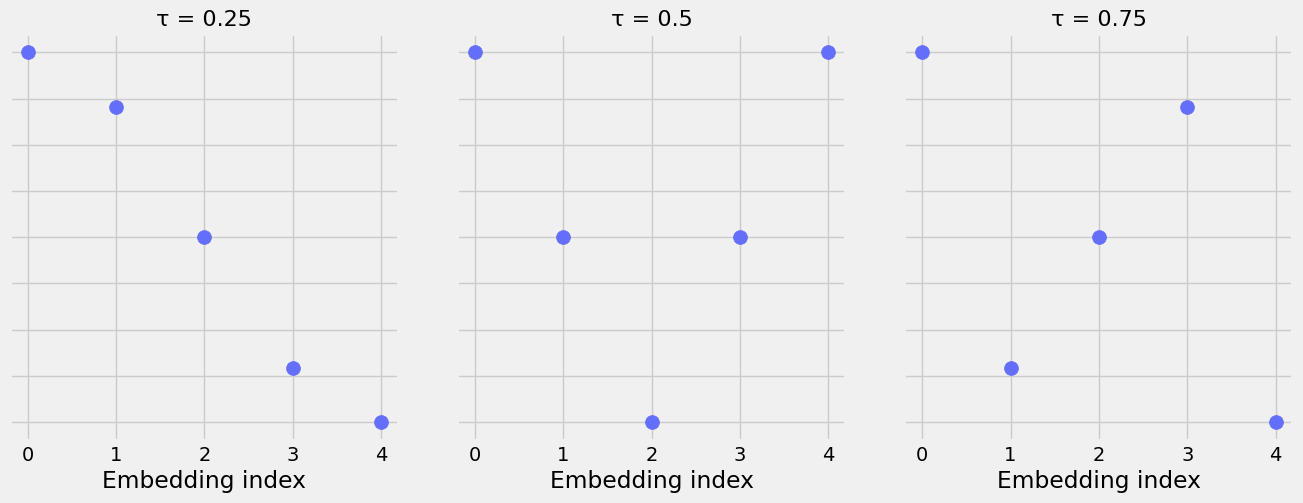

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Function to calculate cosine embeddings for a given tau value and number of dimensions
def calculate_embeddings(tau, n):
    return [np.cos(np.pi * i * tau) for i in range(n)]

# Tau values and the number of embedding dimensions
taus = [0.25, 0.5, 0.75]
n_embeddings = 5

# Dictionary to hold the embeddings for each tau value
embeddings = {tau: calculate_embeddings(tau, n_embeddings) for tau in taus}

# Print each embedding
for tau, embedding in embeddings.items():
    print('Tau:', tau, 'Embedding : ', embedding)
print()
    
# Plot with Matplotlib
fig, axes = plt.subplots(1, len(taus), figsize=(14,6), sharey=True)
for idx, ax in enumerate(axes):
    ax.scatter(range(5), embeddings[taus[idx]], s=100, c='#636EFA')
    ax.set_title(f'τ = {taus[idx]}', fontsize=16)
    ax.set_xlabel('Embedding index')
    if idx > 0:
        axes[idx].set_yticklabels([])
    
plt.tight_layout(pad=3)
plt.show()
# plt.suptitle('Embeddings')

For a higher quality visualisation, we can increase the number of quantiles sampled, as well as the size of the embedding. Let's use an embedding of size 64, and sample from 19 quantiles, which corresponds to every 5th percentile:

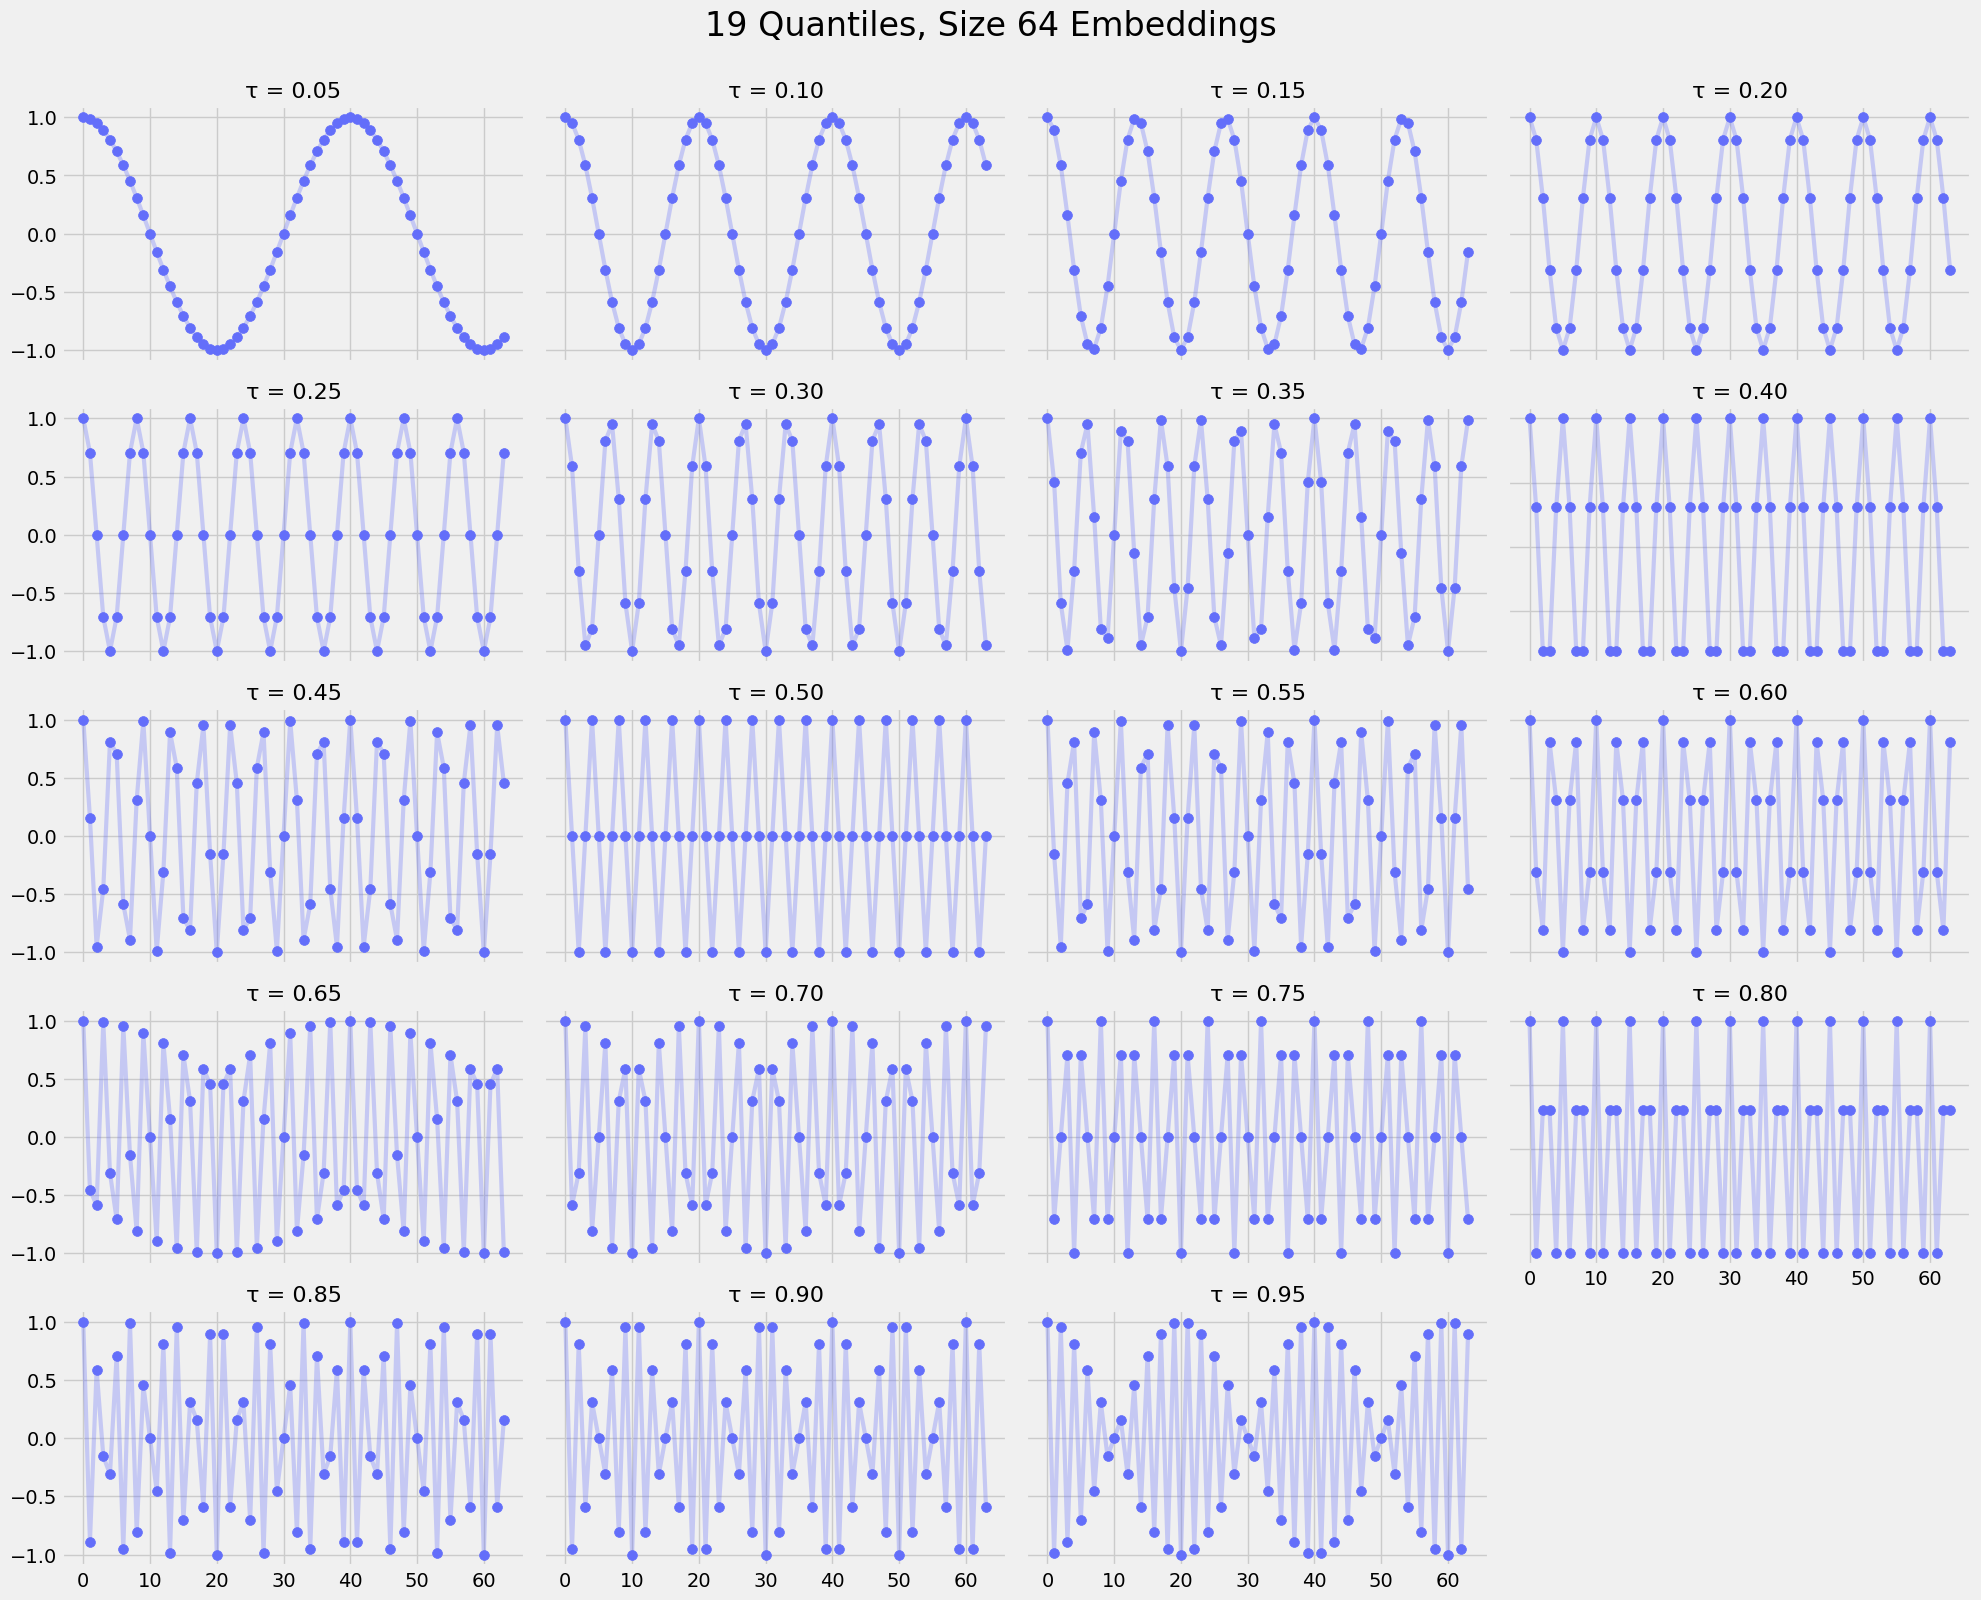

In [3]:
# Updated Tau values for every 5th percentile and the number of embedding dimensions
taus = np.linspace(0, 1, 19 + 2)[1: -1]
n_embeddings = 64
embeddings = {tau: calculate_embeddings(tau, n_embeddings) for tau in taus}

# Plot with Matplotlib
fig, axes = plt.subplots(5, 4, figsize=(20, 16))
axes_flat = axes.flatten()

for idx, ax in enumerate(axes_flat[:-1]):  # Ignore the last subplot
    if idx < len(taus): 
        tau = taus[idx]
        ax.scatter(range(n_embeddings), embeddings[tau], s=50, c='#636EFA')
        ax.plot(range(n_embeddings), embeddings[tau], lw=3, alpha=0.3, c='#636EFA')
        ax.set_title(f'τ = {tau:.2f}', fontsize=16)
        ax.grid(True)

        # Hide y axis labels except on leftmost plots
        if idx % 4 != 0: 
            ax.set_yticklabels([])

        # Only show x-axis labels on the bottom row
        if idx < len(taus) - 4:
            ax.set_xticklabels([])

# Hide the last subplot (bottom right corner) as it's not used
axes_flat[-1].set_visible(False)

plt.suptitle("19 Quantiles, Size 64 Embeddings", fontsize=24, y=1.0)
plt.tight_layout(pad=1)
plt.show()

#### Thoughts:
- $\tau$ values that are nearby each other look relatively similar, ones that are further away generally become more dissimilar.
- There is also some symmetry about the median $\tau = 0.5$, though this is less pronounced than the local similarity.

With this, we've converted each of our 19 $\tau$ values to a length 64 embedding vector. If we revisit the equation:
$$
\phi_j(\tau) := \text{ReLU} \left( \sum^{n-1}_{i=0} \text{cos}(\pi i \tau) w_{ij} + b_j\right)\\
$$
We have just computed the $\text{cos}(\pi i \tau)$ term, all that's left to do is multiply each one by a weight $w_{i}$ and add a bias $b$. This is to say we pass each $\tau$ embedding vector into a dense layer, that learns how to weight each part of the cosine embedding vector.

## IQN Q-Network Architecutre
We'll implement this in PyTorch, with the vanilla DQN and QR-DQN network architectures also written for reference.

In [4]:
import torch 
from torch import nn
import torch.nn.functional as F
import gymnasium as gym

### Vanilla DQN Q-Network ###
class QNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64):
        super().__init__()
        observation_dim  = np.prod(observation_space.shape)
        n_actions   = action_space.n
        
        # Network layers
        self.dense_input  = nn.Linear(observation_dim,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = F.relu(self.dense_input(x))
        x = F.relu(self.dense_hidden(x))
        x = self.dense_output(x)
        return x

### QR DQN Q-Network ###
class QRQNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64,  n_quantiles=49):
        super().__init__()
        observation_dim  = np.prod(observation_space.shape)
        self.n_actions   = action_space.n
        self.n_quantiles = n_quantiles
        
        # Network layers
        self.dense_input  = nn.Linear(observation_dim,  hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, action_space.n * n_quantiles)
        
    def forward(self, x):
        x = F.relu(self.dense_input(x))
        x = F.relu(self.dense_hidden(x))
        x = self.dense_output(x)
        return x.view(-1, self.n_actions, self.n_quantiles)

In [5]:
### IQN Q-Network ###
class IQNetwork(nn.Module):
    def __init__(self, action_space, observation_space, hidden_size=64, n_eval_quantiles=16, cosine_embedding_dim=16):
        super().__init__()
        observation_dim = np.prod(observation_space.shape)
        self.n_actions = action_space.n
        self.hidden_size = hidden_size
        self.n_eval_quantiles = n_eval_quantiles          # When performing action selection, use this many uniformly spaced quantiles        
        self.cosine_embedding_dim = cosine_embedding_dim  # Encode each quantile into an embedding of this many dimensions
        
        # Network layers
        self.dense_input = nn.Linear(observation_dim, hidden_size)
        self.dense_hidden = nn.Linear(hidden_size, hidden_size)
        self.dense_output = nn.Linear(hidden_size, self.n_actions)
        self.tau_embedding = nn.Linear(cosine_embedding_dim, hidden_size)
        
        
    def forward(self, state, taus=None):
        # If no tau values are passed, assume action selection
        if taus is None:
            taus = self.generate_taus(batch_size=state.shape[0], uniform=True).to(state.device)
        
        assert state.shape[0] == taus.shape[0], "Use same batch sizes for state and tau tensors."
        batch_size, n_quantiles = taus.shape
        
        # State encoding
        state_enc = F.relu(self.dense_input(state))
        state_enc = F.relu(self.dense_hidden(state_enc))
        
        # Tau encoding
        pi_i = torch.pi * torch.arange(self.cosine_embedding_dim, device=state.device)
        cos_pi_i_tau = torch.cos(taus.unsqueeze(-1) * pi_i)
        tau_enc = F.relu(self.tau_embedding(cos_pi_i_tau.view(batch_size * n_quantiles, self.cosine_embedding_dim)))
        
        # Combine encodings with Hadamard product
        combined_enc = state_enc.unsqueeze(-1) * tau_enc.view(batch_size, self.hidden_size, n_quantiles)
        output_enc   = self.dense_output(combined_enc.view(batch_size * n_quantiles, self.hidden_size))
        
        return output_enc.view(batch_size, self.n_actions, n_quantiles)
    
    def generate_taus(self, batch_size=1, uniform=False):
        if uniform:
            return torch.linspace(0, 1, self.n_eval_quantiles + 2)[1:-1].expand((batch_size, self.n_eval_quantiles))
        return torch.rand((batch_size, self.n_eval_quantiles))

#### Forward explanation:
The forward method is somewhat complex, so let's go through it:

- `state` denotes the state tensor, `shape=(batch_size, observation_dim)`
- `taus` denote a tensor of quantiles, `shape=(batch_size, n_quantiles)`

#### State encoding
The `state` tensor is passed through the `dense_input` and `dense_hidden` layers, resulting in a tensor of shape `(batch_size, hidden_size)`

#### Tau encoding
Variables are named so they're in accordance with:
$$
\phi_j(\tau) := \text{ReLU} \left( \sum^{n-1}_{i=0} \text{cos}(\pi i \tau) w_{ij} + b_j\right)\\
$$

- `pi_i` is a range of numbers between 0 and `cosine_embeddding_dim` - 1, shape `(cosine_embedding_dim)`
- `cos_pi_i_tau` reshapes `taus` to `(batch_size, n_quantiles, 1)`, then multiplies it by `pi_i` which broadcasts `pi_i` across the last dimension of `taus`, resulting in a tensor shaped `(batch_size, n_quantiles, cosine_embedding_dim)`. An elementwise cosine operation is then performed on this tensor to get `cos_pi_i_tau`.
- The `cos_pi_i_tau` tensor is then reshaped to `(batch_size * n_quantiles, cosine_embedding_dim)`, then passed through the `tau_embedding` layer, followed by elementwise ReLU activation, resulting in `tau_enc`.

#### Combined encoding
- `state_enc` is reshaped to `(batch_size, hidden_size, 1)`, which is then multiplied elementwise (Hadamard product) by `tau_enc`, which is reshaped to `(batch_size, hidden_size, n_quantiles)`, causing the `n_quantiles` dimension to be broadcast over the singleton dimension in `state_enc`, resulting in `combined_enc`, a tensor of shape `(batch_size, hidden_size, n_quantiles)`.

#### Output
- `combined_enc` is then reshaped to `batch_size * n_quantiles, hidden_size` and passed through the `dense_output` layer.
- The final output is then reshaped to `(batch_size, n_actions, n_quantiles)`.

## Action Selection
For IQN, action selection needs to be redefined. Unlike QR-DQN or C51, we're learning a continuous quantile function, meaning we don't have a discrete number of quantiles.

Formally, the expected value of our quantile distribution is:

$$
E[Q(s, a)] = \int_{0}^{1} Q(s, a, \tau) d\tau
$$

We use the approximation:

$$
\hat{E}[Q(s, a)] \approx \frac{1}{N} \sum_{i=1}^{N} Q(s, a, \tau_i)
$$

In practice this is done by getting the Q-values for a number of uniform quantiles in our continous quantile function and performing a mean reduction.

In [6]:
def select_action(network, state):
    "Selects an action for the current state. If no tau values are provided, uniform ones will be generated."
    network_output = network.forward(state)
    expected_q = torch.mean(network_output, dim=2)
    action = torch.argmax(expected_q, dim=1).item()
    return action

## Loss Calculation
We can use the same loss calculation used by QR-DQN, *quantile Huber loss*. I go over this loss calculation in more detail in [my QR-DQN implementation](https://www.kaggle.com/code/auxeno/quantile-regression-dqn-rl).

Unlike in QR-DQN however, IQN doesn't use fixed quantiles. For loss calculation, we will randomly generate $N'$ number of quantiles $\tau_i$ (referred to as `n_eval_quantiles` in our code) from a uniform distribution $U[0, 1]$ for each sampled experience. A method to do so is defined in our network class.

Other than this, loss calculation remains the same as QR-DQN. In this implementation I also include the double DQN calculation.

## Full IQN Implementation
Below is the full code for my IQN implementation:

In [7]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import gymnasium as gym
from collections import deque
import random
import time


### IQN Q-Network ###
class IQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64, num_eval_quantiles=16, cosine_embedding_dim=16):
        super().__init__()
        self.num_actions = action_dim
        self.hidden_dim = hidden_dim
        self.num_eval_quantiles = num_eval_quantiles     
        self.cosine_embedding_dim = cosine_embedding_dim
        
        self.input_layer  = nn.Linear(state_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.tau_embedding_layer = nn.Linear(cosine_embedding_dim, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim, 1)
        self.advantage_layer = nn.Linear(hidden_dim, self.num_actions)
        self.advantage_layer.weight.data *= 0.01
        
    def forward(self, state, taus=None):
        if taus is None:
            taus = self.generate_taus(batch_size=state.shape[0], uniform=True).to(state.device)
        
        assert state.shape[0] == taus.shape[0], "Use same batch sizes for state and tau tensors."
        batch_size, n_quantiles = taus.shape
        
        # State encoding
        state_enc = F.relu(self.input_layer(state))
        state_enc = F.relu(self.hidden_layer(state_enc))
        
        # Tau encoding
        pi_i = torch.pi * torch.arange(self.cosine_embedding_dim, device=state.device)
        cos_pi_i_tau = torch.cos(taus.unsqueeze(-1) * pi_i)
        tau_enc = F.relu(self.tau_embedding_layer(cos_pi_i_tau.view(batch_size * n_quantiles, self.cosine_embedding_dim)))
        
        # Combine encodings with Hadamard product
        combined_enc = state_enc.unsqueeze(-1) * tau_enc.view(batch_size, self.hidden_dim, n_quantiles)
        
        # Dueling
        value = self.value_layer(combined_enc.view(batch_size * n_quantiles, self.hidden_dim))
        advantages = self.advantage_layer(combined_enc.view(batch_size * n_quantiles, self.hidden_dim))
        q_values = value + advantages - advantages.mean(dim=1, keepdim=True)
        
        return q_values.view(batch_size, self.num_actions, n_quantiles)
    
    def generate_taus(self, batch_size=1, uniform=False):
        if uniform:
            return torch.linspace(0, 1, self.num_eval_quantiles + 2)[1:-1].expand((batch_size, self.num_eval_quantiles))
        return torch.rand((batch_size, self.num_eval_quantiles))
    
    
### Experience Replay Buffer ###
class ReplayBuffer:
    def __init__(self, capacity, num_steps=1, gamma=0.99):
        self.buffer = deque(maxlen=capacity)
        self.num_steps = num_steps
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=num_steps)
        
    def add(self, transition):
        "Pushes transition to buffer and handles n-step logic if required."
        assert len(transition) == 6, "Use new Gym step API: (s, a, r, s', ter, tru)"
        if self.num_steps == 1:
            state, action, reward, next_state, terminated, _ = transition
            self.buffer.append((state, action, reward, next_state, terminated))
        else:
            self.n_step_buffer.append(transition)
            
            # Calculate n-step reward
            _, _, _, final_state, final_termination, final_truncation = transition
            n_step_reward = 0.
            for _, _, reward, _, _, _ in reversed(self.n_step_buffer):
                  n_step_reward = n_step_reward * self.gamma + reward
            state, action, _, _, _, _ = self.n_step_buffer[0]

            # If n-step buffer is full, append to main buffer
            if len(self.n_step_buffer) == self.num_steps:
                self.buffer.append((state, action, n_step_reward, final_state, final_termination))
            
            # If done, clear n-step buffer
            if final_termination or final_truncation:
                self.n_step_buffer.clear()
        
    def sample(self, batch_size):
        "Samples a batch of experiences for learner to learn from."
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        states      = torch.tensor(np.stack(states),      dtype=torch.float32)
        actions     = torch.tensor(actions,               dtype=torch.int64  )
        rewards     = torch.tensor(rewards,               dtype=torch.float32)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32)
        dones       = torch.tensor(dones,                 dtype=torch.float32)
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)
    
    
### Linear Scheduler ###
class LinearScheduler:
    "Used to create variables whose values are linearly annealed over time."
    def __init__(self, start, end, total_duration, fraction=1.):
        self.start = start
        self.end = end
        self.total_duration = total_duration
        self.duration = int(total_duration * fraction)
        self.step = 0
        
    def get(self):
        "Gets current value without incrementing step counter."
        if self.step < self.duration:
            current_value = self.start + (self.end - self.start) * (self.step / self.duration)
        else:
            current_value = self.end
        return current_value

    def __call__(self):
        "Gets current value and increments step counter."
        current_value = self.get()
        self.step += 1
        return current_value    

    
### IQN Agent Class ###
class IQN:
    def __init__(self, config):
        self.device = config['device']
        self.env = gym.make(config['env_name'])
        state_dim = np.prod(self.env.observation_space.shape)
        action_dim = self.env.action_space.n
        self.online_network = IQNetwork(state_dim, 
                                        action_dim, 
                                        config['hidden_dim'], 
                                        config['num_eval_quantiles'], 
                                        config['cosine_embedding_dim']).to(self.device)
        self.target_network = IQNetwork(state_dim, 
                                        action_dim, 
                                        config['hidden_dim'], 
                                        config['num_eval_quantiles'], 
                                        config['cosine_embedding_dim']).to(self.device)
        self.update_target_network(1.)
        self.optimizer = torch.optim.AdamW(self.online_network.parameters(), lr=config['lr'])
        self.buffer = ReplayBuffer(config['buffer_capacity'], config['num_steps'], config['gamma'])
        self.epsilon = LinearScheduler(config['eps_start'], config['eps_final'], 
                                       config['total_steps'], config['eps_fraction'])
        self.config = config
        
    def update_target_network(self, tau):
        "Updates the parameters of the target network, tau controls how fully the weights are copied."
        for target_param, online_param in zip(self.target_network.parameters(), self.online_network.parameters()):
            target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
                
    def select_action(self, state, epsilon):
        "Epsilon greedy action selection."
        if random.random() < epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, device=self.config['device']).unsqueeze(0)
        return self.online_network(state_tensor).mean(-1).argmax().item()
    
    def learn(self):
        # Load batch and create tensors
        states, actions, rewards, next_states, dones = self.buffer.sample(self.config['batch_size'])
        states = states.to(self.device)
        actions = actions.to(self.device).view(-1, 1, 1)
        rewards = rewards.to(self.device).view(-1, 1, 1)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device).view(-1, 1, 1)
        
        # Generate taus
        taus = self.online_network.generate_taus(batch_size=self.config['batch_size'], uniform=False).to(self.config['device'])
        
        # Get number of quantiles from config
        n_quantiles = self.config['num_eval_quantiles']
        
        # Predicted Q-value quantiles for current state
        current_state_q_values = self.online_network(states, taus)
        
        # Gather Q-value quantiles of actions actually taken
        current_action_q_values = torch.gather(current_state_q_values, dim=1, index=actions.expand(-1, -1, n_quantiles))
        
        # Compute targets
        with torch.no_grad():
            # Get best actions in next state with double DQN then gather Q-values with these actions
            next_state_q_values     = self.target_network(next_states, taus)
            next_state_best_actions = torch.argmax(self.online_network(next_states).mean(dim=2), dim=1, keepdims=True).unsqueeze(-1)
            next_state_max_q_values = torch.gather(next_state_q_values, dim=1, index=next_state_best_actions.expand(-1, -1, n_quantiles))
            
            # Bellman equation to compute target Q-values for not done states
            target_q_values = rewards + self.config['gamma'] ** self.config['num_steps'] * next_state_max_q_values * (1 - dones)
        
        # Calculate TD error and Quantile Huber loss
        kappa = self.config['kappa']
        td_error = target_q_values - current_action_q_values
        huber_loss = torch.where(td_error.abs() <= kappa, 
                                 0.5 * td_error.pow(2), 
                                 kappa * (td_error.abs() - 0.5 * kappa))
        quantile_loss = torch.abs(taus.unsqueeze(1) - (td_error < 0).float()) * huber_loss
        loss = quantile_loss.mean()
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train(self):
        "Trains agent for a given number of steps according to given configuration."
        print("Training IQN agent\n")
            
        # Logging information
        logs = {'episode_count': 0, 'episodic_reward': 0., 'episode_rewards': [], 'start_time': time.time()}
        
        # Reset episode
        state, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, self.config['total_steps'] + 1):
            # Get action and execute in envrionment
            action = self.select_action(state, self.epsilon())
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            
            # Update logs
            logs['episodic_reward'] += reward
            
            # Push experience to buffer
            self.buffer.add((state, action, reward, next_state, terminated, truncated))

            if terminated or truncated:
                state, _ = self.env.reset()
                
                # Update logs
                logs['episode_count'] += 1
                logs['episode_rewards'].append(logs['episodic_reward'])
                logs['episodic_reward'] = 0.
            else:
                state = next_state
            
            # Perform learning step
            if len(self.buffer) >= self.config['batch_size'] and step > self.config['learning_starts']:
                self.learn()
            
            # Update target network
            if step % self.config['target_update'] == 0:
                self.update_target_network(self.config['tau'])
                
            # If mean of last 20 rewards exceed target, end training
            if len(logs['episode_rewards']) > 0 and np.mean(logs['episode_rewards'][-20:]) >= self.config['target_reward']:
                break
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0 and len(logs['episode_rewards']) > 0:
                print(f"\r--- {100 * step / self.config['total_steps']:.1f}%" 
                      f"\t Step: {step:,}"
                      f"\t Mean Reward: {np.mean(logs['episode_rewards'][-20:]):.2f}"
                      f"\t Epsilon: {self.epsilon.get():.2f}"
                      f"\t Episode: {logs['episode_count']:,}"
                      f"\t Duration: {time.time() - logs['start_time']:,.1f}s  ---", end='')
                if step % 10000 == 0:
                    print()
                    
        # Training ended
        print("\n\nTraining done")
        logs['end_time'] = time.time()
        logs['duration'] = logs['end_time'] - logs['start_time']
        return logs
    
        
### IQN Configuration ###
iqn_config = {
    'env_name'            : 'CartPole-v1',  # Gym environment to use
    'device'              :         'cpu',  # Device used for learning
    'total_steps'         :         50000,  # Total training steps
    'hidden_dim'          :            16,  # Number of neurons in Q-network hidden layer
    'batch_size'          :            64,  # Number of experience tuples sampled per learning update
    'buffer_capacity'     :        100000,  # Maximum length of replay buffer
    'target_update'       :            50,  # How often to perform target network weight synchronisations
    'tau'                 :           0.5,  # When copying online network weights to target network, what weight is given to online network weights
    'eps_start'           :           0.8,  # Initial epsilon to use
    'eps_final'           :           0.1,  # Lowest possible epsilon value
    'eps_fraction'        :          0.25,  # Fraction of entire training period over which the exploration rate is reduced
    'learning_starts'     :            80,  # Step to begin learning at
    'train_frequency'     :             1,  # Performs a learning update every `train_frequency` steps
    'lr'                  :          1e-3,  # Learning rate
    'gamma'               :          0.99,  # Discount factor
    'num_steps'           :             1,  # Multistep reward steps
    'kappa'               :           1.0,  # Huber loss kappa
    'num_eval_quantiles'  :             8,  # N in the IQN paper, resolution of the quantile distribution used
    'cosine_embedding_dim':             8,  # N' in IQN paper, dimensionality of cosine embeddings generated
    'target_reward'       :           195,  # If set to a number, training will stop when mean reward for recent episodes exceeds this
    'verbose'             :          True,  # Prints steps and rewards in output
}

## Train IQN Agent
Our IQN agent is trained on Gym's simple Cartpole environment.

In [8]:
agent = IQN(iqn_config)
logs = agent.train()

Training IQN agent

--- 20.0%	 Step: 10,000	 Mean Reward: 97.05	 Epsilon: 0.24	 Episode: 287	 Duration: 40.9s  ---
--- 35.0%	 Step: 17,500	 Mean Reward: 193.65	 Epsilon: 0.10	 Episode: 335	 Duration: 73.4s  ---

Training done
